In [19]:
# Requirements

import math

from IPython import display
from matplotlib import cm
from matplotlib import gridspec
from matplotlib import pyplot as plt

import numpy as np
import pandas as pd

from sklearn import metrics
# importation de la version 1 de tensor flow
# Des erreurs sont apparues avec la version 2 que je n'ai pas su corriger
%tensorflow_version 1.x
import tensorflow as tf
from tensorflow.python.data import Dataset

import logging
logging.getLogger("tensorflow").setLevel(logging.ERROR)

# parametres de print dans le terminal
pd.set_option('display.max_rows', 15)
pd.set_option('display.max_columns', 15)
pd.set_option('display.width', 1000)

pd.options.display.float_format = '{:.1f}'.format
# print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

On charge les données qui nous serviront de base : données sur l'immobilier en Californie


In [20]:

california_housing_dataframe = pd.read_csv("https://download.mlcc.google.com/mledu-datasets/california_housing_train.csv", sep=",")
print(california_housing_dataframe.head(15), '\n\n')

    longitude  latitude  housing_median_age  total_rooms  total_bedrooms  population  households  median_income  median_house_value
0      -114.3      34.2                15.0       5612.0          1283.0      1015.0       472.0            1.5             66900.0
1      -114.5      34.4                19.0       7650.0          1901.0      1129.0       463.0            1.8             80100.0
2      -114.6      33.7                17.0        720.0           174.0       333.0       117.0            1.7             85700.0
3      -114.6      33.6                14.0       1501.0           337.0       515.0       226.0            3.2             73400.0
4      -114.6      33.6                20.0       1454.0           326.0       624.0       262.0            1.9             65500.0
5      -114.6      33.6                29.0       1387.0           236.0       671.0       239.0            3.3             74000.0
6      -114.6      33.6                25.0       2907.0           680.0    

Méthode de mélange aléatoire des données des données:

L'objectif est d'eviter les effets de classements pathologique pouvant nuire aux performanes de la descente de gradient stochastique

In [21]:
california_housing_dataframe = california_housing_dataframe.reindex(np.random.permutation((california_housing_dataframe.index)))


Creation de la fonction qui prepare les features à selectionner :

In [22]:
def preparation_features(dataframe):

    # Selection des features qui nous interessent
    selected_features = dataframe[[
        "latitude",
        "longitude",
        "housing_median_age",
        "total_rooms",
        "total_bedrooms",
        "population",
        "households",
        "median_income"
    ]]

    processed_features = selected_features.copy()

    processed_features["rooms_per_person"] = (dataframe["total_rooms"]/dataframe["population"])

    return processed_features

# test de la fonction 
print(preparation_features(california_housing_dataframe).head(5))

       latitude  longitude  housing_median_age  total_rooms  total_bedrooms  population  households  median_income  rooms_per_person
4024       33.9     -118.0                35.0       1928.0           360.0      1056.0       366.0            4.1               1.8
2298       33.9     -117.4                32.0       2349.0           452.0      1479.0       425.0            3.9               1.6
1408       33.0     -117.2                 4.0      19001.0          2688.0      8980.0      2441.0            6.3               2.1
13112      37.3     -121.9                44.0       1267.0           353.0      1018.0       327.0            2.4               1.2
9454       35.9     -119.3                24.0       1590.0           390.0      1686.0       372.0            1.6               0.9


Creation de la fonction qui prepare les targets ( aussi appelés labels ) :


In [23]:
def preparation_targets_labels(dataframe):

    output_targets = pd.DataFrame()
    output_targets["median_house_value"] = (dataframe["median_house_value"]/1000.0)

    return output_targets

# test de la fonction 
print(preparation_targets_labels(california_housing_dataframe).head(5))

       median_house_value
4024                215.7
2298                114.1
1408                260.9
13112               194.4
9454                 47.6



Preparation des différents ensembles de données nécessaires à l'expérience : 


In [24]:
# Preparation des l'ensemdle d'entrainement avec les labels associés
training_exemples = preparation_features(california_housing_dataframe.head(12000))
training_targets = preparation_targets_labels(california_housing_dataframe.head(12000))

# Preparation de l'ensemble de validation ( features + labels )

validation_exemples = preparation_features(california_housing_dataframe.tail(5000))
validation_targets = preparation_targets_labels(california_housing_dataframe.tail(5000))

Creation de la fonction de creation de figure latitudexlongitude. Cela apporte deux informations. 

1 - Avoir une représentation géograpgique de la zone géographique couverte 

2 - Observer une repartition homogène des données entre l'ensemble d'entrainement et l'ensemble de validation 


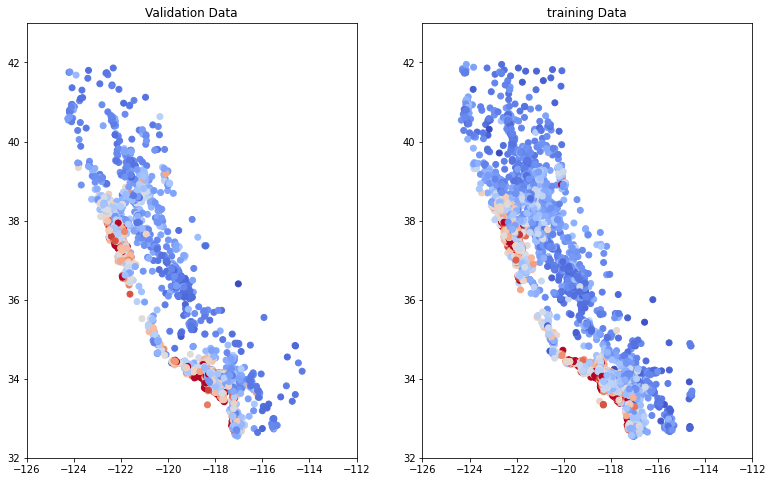

In [25]:
def plot_data_log_lat(vale,valt, traine,traint):

    plt.figure(figsize=(13, 8))

    ax = plt.subplot(1,2,1)
    ax.set_title("Validation Data")

    ax.set_autoscaley_on(False)
    ax.set_ylim([32,43])
    ax.set_autoscaley_on(False)
    ax.set_xlim([-126, -112])
    plt.scatter(vale["longitude"], vale["latitude"], cmap="coolwarm", c=valt["median_house_value"]/valt["median_house_value"].max())


    ax = plt.subplot(1,2,2)
    ax.set_title("training Data")
    ax.set_autoscaley_on(False)
    ax.set_ylim([32,43])
    ax.set_autoscaley_on(False)
    ax.set_xlim([-126, -112])
    plt.scatter(traine["longitude"], traine["latitude"], cmap="coolwarm",c=traint["median_house_value"] / traint["median_house_value"].max())


    plt.plot()
    # plt.show()



plot_data_log_lat(validation_exemples, validation_targets, training_exemples, training_targets)


Creation de la fonction qui formate les données pour les inserer dans le modèle. 

On parle d'input_fonction. On passe nos données selectionnées en entrée et elle crée le dataset divisé en batch equivalent et renvoie les couples features, labels


Mais avant ça il faaut creer un iterateur sur les données qu'on utilisera dans cette fonction. En effet dans la v2 de tensorflow on a besoin de cette methode. Si on utilise la V1 de tensorflow alors on peut utiliser la partie commentée


In [26]:
@tf.function
def iterateur(dataset):
  iterator = iter(dataset)
  return next(iterator)


In [27]:
def my_input_fonction(features, targets, batch_size=1, shuffle=True, num_epochs = None):
    # Les arguments sont :
    # features : les colonnes du dataframes qui servent de données
    # targets :  La colonne de données d'apprentissage qu'on cherche à predire plus tard
    # Si shuffle est True les données seront lues de manière aléatoire de manière à etre transmises de manière aleatoire au modèle au cours de l'apprentissage

    # Convertir les données du dataframe en un dictionnaire de tableaux
    features = {key:np.array(value) for key,value in dict(features).items()}
    # print('Dictionnaire de tableaux features : \n\n', features, '\n\n')

    #Construire un dataset et configurer le batching

    Data_set = Dataset.from_tensor_slices((features, targets))
    Data_set = Data_set.batch(batch_size).repeat(num_epochs)

    # print('This is the dataset : \n\n', Data_set, '\n\n')


    # Melanger la Data  :
    if shuffle:
        Data_set =Data_set.shuffle(10000)

    

    # Retourner la batch de données

    # features, labels = Data_set.make_one_shot_iterator().get_next() # Cette fonction n'est plus valable dans TF V2 , seulement dans V1
    features, labels = tf.compat.v1.data.make_one_shot_iterator(Data_set).get_next()
    
    # features, labels = iterateur(Data_set)

    
    # print('this is the features output : \n\n', features, '\n\n this is the labels in Output : \n\n', labels)

    return features,labels

# Test fonction : 
print(my_input_fonction(training_exemples, training_targets, batch_size=5, shuffle=True, num_epochs = 1))


# Et ça ressemble à cette données
exemple = {'feature1':['value1','value2','value3'], 'feature2':['value1','value2','value3'],'feature3':['value1','value2','value3']}
print(exemple, '\n Il y a autant de valeur par features que la taille du batch saisie')


({'latitude': <tf.Tensor 'IteratorGetNext_1:2' shape=(?,) dtype=float64>, 'longitude': <tf.Tensor 'IteratorGetNext_1:3' shape=(?,) dtype=float64>, 'housing_median_age': <tf.Tensor 'IteratorGetNext_1:1' shape=(?,) dtype=float64>, 'total_rooms': <tf.Tensor 'IteratorGetNext_1:8' shape=(?,) dtype=float64>, 'total_bedrooms': <tf.Tensor 'IteratorGetNext_1:7' shape=(?,) dtype=float64>, 'population': <tf.Tensor 'IteratorGetNext_1:5' shape=(?,) dtype=float64>, 'households': <tf.Tensor 'IteratorGetNext_1:0' shape=(?,) dtype=float64>, 'median_income': <tf.Tensor 'IteratorGetNext_1:4' shape=(?,) dtype=float64>, 'rooms_per_person': <tf.Tensor 'IteratorGetNext_1:6' shape=(?,) dtype=float64>}, <tf.Tensor 'IteratorGetNext_1:9' shape=(?, 1) dtype=float64>)
{'feature1': ['value1', 'value2', 'value3'], 'feature2': ['value1', 'value2', 'value3'], 'feature3': ['value1', 'value2', 'value3']} 
 Il y a autant de valeur par features que la taille du batch saisie


Ensuite il faut créer une fonction qui va generer un ensemble de tous les types de features à utiliser. 

En effet il faut indiquer au modèle pour chaque feature qu'il croisera quel est le type des données contenu ( ex : données numériques, données textuelles , etc ... )

In [28]:
def creation_features_description(input_features):
    return set([tf.feature_column.numeric_column(my_feature) for my_feature in input_features])

# Test fonction 
print(creation_features_description(training_exemples))

{NumericColumn(key='population', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None), NumericColumn(key='total_bedrooms', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None), NumericColumn(key='longitude', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None), NumericColumn(key='housing_median_age', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None), NumericColumn(key='latitude', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None), NumericColumn(key='rooms_per_person', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None), NumericColumn(key='total_rooms', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None), NumericColumn(key='households', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None), NumericColumn(key='median_income', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None)}


Creation de la fonction principale où l'on va creer notre réseau de neurones et l'entrainer.

Le paramètre hidden_units defini le nombre de couche ainsi que le nombre de neurones par couche fully connected.

Par defaut la fonction d'activation est une fonction ReLu



In [29]:
def train_neural_network_regression_model(learning_rate, steps, batch_size, hidden_units, training_exemples, training_targets, validation_exemples,validation_targets):    

    periods = 10
    steps_per_period = steps / periods

    # creation du réseau de neurones :

    # my_optimizer = tf.optimizers.SGD(learning_rate=learning_rate, name='SGD', clipnorm=5.0)
    # my_optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate, name='SGD', clipnorm=5.0)
    my_optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
    my_optimizer = tf.contrib.estimator.clip_gradients_by_norm(my_optimizer, 5.0)
    
    Deep_neural_network_regressor = tf.estimator.DNNRegressor(
      feature_columns= creation_features_description(training_exemples),
      hidden_units = hidden_units,
      optimizer= my_optimizer
    )

    # Clairement on utilise un modèle tout fait et on lui defini sa structure avec le paramètre hidden_units

    # creation des données:
    generate_final_training_data = lambda: my_input_fonction(training_exemples, training_targets["median_house_value"], batch_size=batch_size)    
    generate_final_training_data_for_prediction = lambda: my_input_fonction(training_exemples, training_targets["median_house_value"], num_epochs=1,shuffle=False)
    generate_final_validation_data_for_prediction = lambda: my_input_fonction(validation_exemples, validation_targets["median_house_value"], num_epochs=1, shuffle=False)

    #       Entrainement du modèle :
    print("Training model...\n")
    print("RMSE (on training data):\n")

    training_rmse=[]
    validation_rmse=[]

    for period in range(0, periods):         

      #etape d'entrainement:
      Deep_neural_network_regressor.train(
          input_fn= generate_final_training_data,
          steps= steps_per_period,
      )

      #le reseau a été un peu entrainé on va essayer de mesurer les resultats de son apprentissage:
      # On calcule alors les predictions sur le modèle entrainé :
      training_predictions = Deep_neural_network_regressor.predict(input_fn= generate_final_training_data_for_prediction )
      training_predictions = np.array([item['predictions'][0] for item in training_predictions])

      #on fait pareil sur les données de validation:
      validation_predictions = Deep_neural_network_regressor.predict(input_fn=generate_final_validation_data_for_prediction )
      validation_predictions = np.array([item['predictions'][0] for item in validation_predictions])

      #on calcule les perte d'entrainement et la perte de validation

      training_rmse_computation = math.sqrt(metrics.mean_squared_error(training_predictions, training_targets))
      validation_rmse_computation = math.sqrt(metrics.mean_squared_error(validation_predictions, validation_targets))

      print(" period %02d : %0.2f" % (period, training_rmse_computation))
      training_rmse.append(training_rmse_computation)
      validation_rmse.append(validation_rmse_computation)

    print("Model training finished")

    plt.ylabel("RMSE")
    plt.xlabel("Periods")
    plt.title("Root Mean Squared Error vs. Periods")
    plt.tight_layout()
    plt.plot(training_rmse, label="training")
    plt.plot(validation_rmse, label="validation")
    plt.legend()
    plt.show()

    return Deep_neural_network_regressor
 


Lancement du modèle :

Training model...

RMSE (on training data):

 period 00 : 158.44
 period 01 : 153.60
 period 02 : 153.77
 period 03 : 146.81
 period 04 : 144.76
 period 05 : 136.08
 period 06 : 127.65
 period 07 : 120.54
 period 08 : 112.47
 period 09 : 108.03
Model training finished


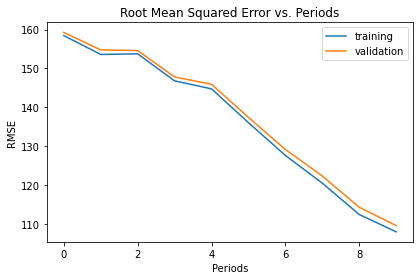

DONE


In [30]:
_ = train_neural_network_regression_model(
    learning_rate=0.001,
    steps=2000,
    batch_size=100,
    hidden_units = [10, 10],
    training_exemples= training_exemples,
    training_targets= training_targets,
    validation_exemples= validation_exemples,
    validation_targets= validation_targets    
    )
# 
print("DONE")

On vient ensuite verifier que nos performances de validation restent au même niveau sur les données tests

In [32]:
california_housing_test_data = pd.read_csv("https://download.mlcc.google.com/mledu-datasets/california_housing_test.csv", sep=",")

test_examples = preparation_features(california_housing_test_data)
test_targets = preparation_targets_labels(california_housing_test_data)

predict_test_input_fn = lambda: my_input_fonction(
      test_examples, 
      test_targets["median_house_value"], 
      num_epochs=1, 
      shuffle=False)

test_predictions = _.predict(input_fn=predict_test_input_fn)
test_predictions = np.array([item['predictions'][0] for item in test_predictions])

root_mean_squared_error = math.sqrt(
    metrics.mean_squared_error(test_predictions, test_targets))

print("Final RMSE (on test data): %0.2f" % root_mean_squared_error)

Final RMSE (on test data): 106.75


On va maintenant essayer d'ameliorere ces resultats en metant à l'echelle les données pour qu'elles soient comprises entre -1 et 1. 

On va aussi changer l'optimisateur afin qu'il corresponde mieux à nos problèmes et ainsi donner de meilleurs résulats

In [33]:
# creation de la fonction de mise à l'echelle 

def linear_scale(series):
  min_val = series.min()
  max_val = series.max()
  scale = (max_val - min_val)/2
  return series.apply(lambda x: ((x-min_val)/scale)-1.0)

# exemple 
print(linear_scale(california_housing_test_data["population"].head(5)))

0    1.0
1    0.0
2    0.9
3   -1.0
4    0.1
Name: population, dtype: float64


On applique maintenant cette fonction à toutes les features

Pour cela on crée une fonction qui va s'en charger pour nous 


In [37]:
def normalisation_echelle_lineaire(dataframe):
  processed_features = pd.DataFrame()
  processed_features["latitude"] = linear_scale(dataframe["latitude"])
  processed_features["longitude"] = linear_scale(dataframe["longitude"])
  processed_features["housing_median_age"] = linear_scale(dataframe["housing_median_age"])
  processed_features["total_rooms"] = linear_scale(dataframe["total_rooms"])
  processed_features["total_bedrooms"] = linear_scale(dataframe["total_bedrooms"])
  processed_features["population"] = linear_scale(dataframe["population"])
  processed_features["households"] = linear_scale(dataframe["households"])
  processed_features["median_income"] = linear_scale(dataframe["median_income"])
  processed_features["rooms_per_person"] = linear_scale(dataframe["rooms_per_person"])
  return processed_features


In [38]:
# On normalise alors les données avant de les donner au réseau de neurones :

normalized_dataframe = normalisation_echelle_lineaire(preparation_features(california_housing_dataframe))
normalized_training_examples = normalized_dataframe.head(12000)
normalized_validation_examples = normalized_dataframe.tail(5000)


On entraine de nouveau notre réseau de neurones avec ces valeurs normalisées

Training model...

RMSE (on training data):

 period 00 : 165.74
 period 01 : 114.51
 period 02 : 102.36
 period 03 : 85.41
 period 04 : 76.44
 period 05 : 74.15
 period 06 : 72.45
 period 07 : 71.22
 period 08 : 70.69
 period 09 : 70.12
Model training finished


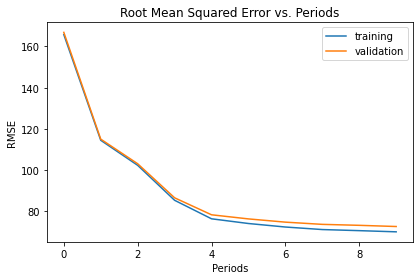

DONE


In [40]:
Normalized_DNN_regressor = train_neural_network_regression_model(
    learning_rate=0.005,
    steps=2000,
    batch_size=50,
    hidden_units = [10, 10],
    training_exemples= normalized_training_examples,
    training_targets= training_targets,
    validation_exemples= normalized_validation_examples,
    validation_targets= validation_targets    
    )
# 
print("DONE")

D'autres optimisateur que le gradientdescentOptimisateur existent.

L'optimiseur AdaGrad constitue une solution. L'idée principale est que cet optimiseur adapte le taux d'apprentissage pour chaque coefficient d'un modèle, en réduisant, de façon monotone, le taux d'apprentissage effectif. Cette méthode fonctionne parfaitement pour les problèmes convexes, mais elle ne s'avère pas toujours idéale pour le problème non convexe d'entraînement des réseaux de neurones. On peut utiliser AdaGrad en indiquant AdagradOptimizer au lieu de GradientDescentOptimizer. Un taux d'apprentissage plus élevé peut être nécessaire avec AdaGrad.

Pour les problèmes d'optimisation non convexes, Adam se révèle parfois plus efficace. Pour utiliser Adam, invoquez la méthode tf.train.AdamOptimizer. Cette méthode utilise plusieurs hyperparamètres facultatifs en tant qu'arguments, mais notre solution n'en spécifie qu'un seul (learning_rate). Dans un environnement de production, vous devez être prudent lorsque vous spécifiez et réglez les hyperparamètres facultatifs.



In [ ]:
other_optimizer_possible = tf.train.AdagradOptimizer(learning_rate=0.5)
other_optimizer_possible = tf.train.AdamOptimizer(learning_rate=0.009)

D'autres methode de normalisation des données sont possibles et nous pouvons egalement appliquer des normalisations différentes selon les features 



In [ ]:
def log_normalize(series):
  return series.apply(lambda x:math.log(x+1.0))

def clip(series, clip_to_min, clip_to_max):
  return series.apply(lambda x:(
    min(max(x, clip_to_min), clip_to_max)))

def z_score_normalize(series):
  mean = series.mean()
  std_dv = series.std()
  return series.apply(lambda x:(x - mean) / std_dv)

def binary_threshold(series, threshold):
  return series.apply(lambda x:(1 if x > threshold else 0))